In [1]:
!pip install pyspark

In [2]:
!pip install pandas
!pip install pandas numpy


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Lukoil Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

24/11/22 01:31:58 WARN Utils: Your hostname, devopsvm resolves to a loopback address: 127.0.1.1; using 192.168.0.171 instead (on interface enp0s3)
24/11/22 01:31:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/22 01:31:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Чтение данных из HDFS
file_path = "hdfs://localhost:9000/vereinams/hadoop/input/LKOH.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Просмотр первых строк данных
df.show(5)

+----------+----------------------+-------------------------------+-------------------------------+-------------------+-------------------+-------------------+----------------------+
|      Date|Number of Transactions|Volume of Transactions (shares)|Volume of Transactions (rubles)|          Max Price|          Min Price|     Percent Change|Number of Participants|
+----------+----------------------+-------------------------------+-------------------------------+-------------------+-------------------+-------------------+----------------------+
|2010-11-23|                 15795|              5442132.515464597|             5.03271638694298E9|                0.0|                0.0| -7.799372001012195|                    29|
|1998-10-27|                   860|           3.0224760740093123E7|            4.762930518470548E9|0.00429153647019218|0.00429153647019218|-11.710583654625012|                   200|
|2022-06-01|                 76820|              6597478.306771004|            2.7492

In [6]:
# Проверка структуры данных и типов столбцов
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Number of Transactions: integer (nullable = true)
 |-- Volume of Transactions (shares): double (nullable = true)
 |-- Volume of Transactions (rubles): double (nullable = true)
 |-- Max Price: double (nullable = true)
 |-- Min Price: double (nullable = true)
 |-- Percent Change: double (nullable = true)
 |-- Number of Participants: integer (nullable = true)



In [7]:
print(df.dtypes)

[('Date', 'date'), ('Number of Transactions', 'int'), ('Volume of Transactions (shares)', 'double'), ('Volume of Transactions (rubles)', 'double'), ('Max Price', 'double'), ('Min Price', 'double'), ('Percent Change', 'double'), ('Number of Participants', 'int')]


In [8]:
df_pd = df.toPandas()
df_pd.head()

,Date,Number of Transactions,Volume of Transactions (shares),Volume of Transactions (rubles),Max Price,Min Price,Percent Change,Number of Participants
0,2010-11-23,15795,5.442133e+06,5.032716e+09,0.000000,0.000000,-7.799372,29
1,1998-10-27,860,3.022476e+07,4.762931e+09,0.004292,0.004292,-11.710584,200
2,2022-06-01,76820,6.597478e+06,2.749233e+09,0.008583,0.008583,8.368011,228
3,2019-01-29,54886,1.718783e+07,7.416754e+09,0.012875,0.012875,-0.676542,353
4,2008-07-20,6265,2.296277e+06,4.177122e+09,0.017166,0.017166,4.645309,373


In [9]:
# Подсчет количества пропущенных значений в каждом столбце
missing_values = df_pd.isnull().sum()
print("Количество пропущенных значений в каждом столбце:")
print(missing_values)

Количество пропущенных значений в каждом столбце:
Date                               0
Number of Transactions             0
Volume of Transactions (shares)    0
Volume of Transactions (rubles)    0
Max Price                          0
Min Price                          0
Percent Change                     0
Number of Participants             0
dtype: int64


In [10]:
df_pd.describe()

,Number of Transactions,Volume of Transactions (shares),Volume of Transactions (rubles),Max Price,Min Price,Percent Change,Number of Participants
count,2.097152e+06,2.097152e+06,2.097152e+06,2.097152e+06,2.097152e+06,2.097152e+06,2.097152e+06
mean,5.001402e+04,1.944060e+07,4.999457e+09,4.500000e+03,4.500000e+03,-5.274294e-03,2.505453e+02
std,2.886152e+04,1.122849e+07,2.886264e+09,2.598078e+03,2.598078e+03,1.443652e+01,1.443636e+02
min,0.000000e+00,9.467930e+01,1.386966e+04,0.000000e+00,0.000000e+00,-2.499998e+01,1.000000e+00
25%,2.502500e+04,9.725092e+06,2.499802e+09,2.250000e+03,2.250000e+03,-1.250609e+01,1.250000e+02
50%,5.001350e+04,1.944261e+07,4.998798e+09,4.500000e+03,4.500000e+03,-4.421235e-03,2.510000e+02
75%,7.500200e+04,2.915813e+07,7.497931e+09,6.750000e+03,6.750000e+03,1.250248e+01,3.760000e+02
max,1.000000e+05,3.888998e+07,9.999999e+09,9.000000e+03,9.000000e+03,2.499996e+01,5.000000e+02


In [11]:
# Сортировка данных по дате

df_sort = df_pd.sort_values(by = 'Date')
df_sort

,Date,Number of Transactions,Volume of Transactions (shares),Volume of Transactions (rubles),Max Price,Min Price,Percent Change,Number of Participants
1850446,1997-01-01,60035,1.566573e+06,9.286410e+08,7941.256495,7941.256495,10.208875,272
1060787,1997-01-01,24599,3.175778e+07,5.776579e+09,4552.406098,4552.406098,9.931988,306
1287007,1997-01-01,66566,1.996447e+07,2.479943e+09,5523.237478,5523.237478,-9.011868,280
289684,1997-01-01,44826,1.768331e+07,7.390749e+09,1243.189451,1243.189451,-24.147486,311
202010,1997-01-01,42882,8.373430e+06,7.269332e+09,866.933282,866.933282,6.506255,48
...,...,...,...,...,...,...,...,...
705820,2024-11-01,27559,1.564816e+07,4.782930e+09,3029.052271,3029.052271,-4.269346,368
810020,2024-11-01,89805,2.769503e+07,1.366661e+08,3476.230372,3476.230372,2.008147,268
1006936,2024-11-01,73009,1.048973e+07,9.958435e+09,4321.302567,4321.302567,-22.481559,304
1947235,2024-11-01,36732,9.767120e+06,9.285064e+09,8356.630019,8356.630019,3.275401,171


In [12]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

In [13]:
df_sort['Date'] = pd.to_datetime(df_sort['Date'])

#Определение последней даты в столбце 'Date'
last_date = df_sort['Date'].max()

# Фильтрация данных за последние 5 лет
five_years_ago = last_date - DateOffset(years=5)
df_filter = df_sort[df_sort['Date'] >= five_years_ago]

# Вывод отфильтрованных данных
df_filter

,Date,Number of Transactions,Volume of Transactions (shares),Volume of Transactions (rubles),Max Price,Min Price,Percent Change,Number of Participants
1826033,2019-11-01,92031,1.741402e+07,9.549088e+09,7836.487215,7836.487215,-0.084452,332
1822104,2019-11-01,47867,3.483438e+07,3.481910e+09,7819.625768,7819.625768,10.126904,260
295526,2019-11-01,74152,2.429457e+07,9.834557e+09,1268.260607,1268.260607,-12.700783,313
1840517,2019-11-01,4130,1.051023e+07,7.644111e+09,7898.645830,7898.645830,-8.713156,248
26319,2019-11-01,82283,2.143909e+07,5.088589e+09,112.948948,112.948948,8.430726,102
...,...,...,...,...,...,...,...,...
705820,2024-11-01,27559,1.564816e+07,4.782930e+09,3029.052271,3029.052271,-4.269346,368
810020,2024-11-01,89805,2.769503e+07,1.366661e+08,3476.230372,3476.230372,2.008147,268
1006936,2024-11-01,73009,1.048973e+07,9.958435e+09,4321.302567,4321.302567,-22.481559,304
1947235,2024-11-01,36732,9.767120e+06,9.285064e+09,8356.630019,8356.630019,3.275401,171


In [14]:
# Расчет минимальной цены закрытия и соответствующей даты

min_price = df_filter['Min Price'].min()  # Минимальная цена закрытия
min_date = df_filter.loc[df_filter['Min Price'].idxmin(), 'Date']  # Дата минимальной цены

print(f"Минимальная цена закрытия за последние 5 лет: {min_price}")
print(f"Дата минимальной цены закрытия: {min_date.date()}")

Минимальная цена закрытия за последние 5 лет: 0.00858307294038436
Дата минимальной цены закрытия: 2022-06-01


In [15]:
# Добавление столбца с годом
df_sort['Year'] = df_sort['Date'].dt.year

# Группировка данных по годам и вычисление агрегированных значений
df_group = df_sort.groupby('Year').agg({
    'Max Price': 'mean',
    'Min Price': 'mean',
    'Percent Change': 'mean',  
    'Volume of Transactions (shares)': 'sum', 
    'Volume of Transactions (rubles)': 'sum',
    'Number of Transactions': 'sum',
    'Number of Participants': 'sum'
}).reset_index()

# Вывод сгруппированных данных
df_group

,Year,Max Price,Min Price,Percent Change,Volume of Transactions (shares),Volume of Transactions (rubles),Number of Transactions,Number of Participants
0,1997,4502.422642,4502.422642,0.017063,1.458816e+12,3.754760e+14,3756348946,18858422
1,1998,4501.919973,4501.919973,-0.053180,1.466237e+12,3.770386e+14,3763351158,18886710
2,1999,4497.162497,4497.162497,-0.027472,1.467540e+12,3.764453e+14,3783518642,18869270
3,2000,4498.297501,4498.297501,-0.041945,1.480071e+12,3.815847e+14,3808919405,19039400
4,2001,4499.268370,4499.268370,-0.043357,1.455909e+12,3.747673e+14,3758559389,18778448
5,2002,4495.581329,4495.581329,0.015471,1.459859e+12,3.766974e+14,3758018242,18878263
6,2003,4501.019552,4501.019552,0.009664,1.461490e+12,3.747500e+14,3751676308,18798307
7,2004,4496.273077,4496.273077,-0.040936,1.477159e+12,3.791449e+14,3795060954,19034042
8,2005,4490.947241,4490.947241,0.009804,1.459750e+12,3.740299e+14,3748322309,18845229
9,2006,4493.647351,4493.647351,0.028786,1.463214e+12,3.764619e+14,3756467918,18832796


In [16]:
!pip install seaborn

In [17]:
df_sort.head()

,Date,Number of Transactions,Volume of Transactions (shares),Volume of Transactions (rubles),Max Price,Min Price,Percent Change,Number of Participants,Year
1850446,1997-01-01,60035,1.566573e+06,9.286410e+08,7941.256495,7941.256495,10.208875,272,1997
1060787,1997-01-01,24599,3.175778e+07,5.776579e+09,4552.406098,4552.406098,9.931988,306,1997
1287007,1997-01-01,66566,1.996447e+07,2.479943e+09,5523.237478,5523.237478,-9.011868,280,1997
289684,1997-01-01,44826,1.768331e+07,7.390749e+09,1243.189451,1243.189451,-24.147486,311,1997
202010,1997-01-01,42882,8.373430e+06,7.269332e+09,866.933282,866.933282,6.506255,48,1997


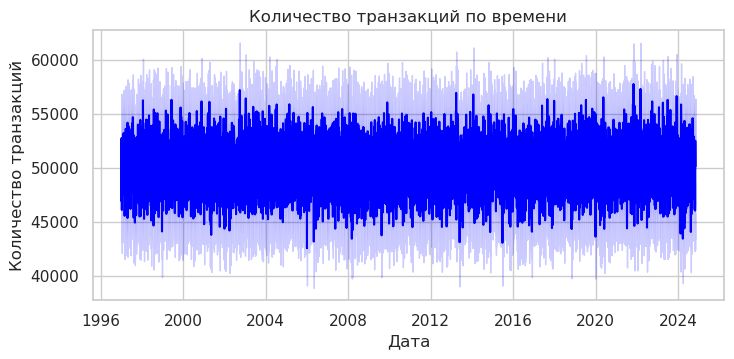

In [18]:
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры для графиков
plt.figure(figsize=(14, 10))

# График количества транзакций
plt.subplot(3, 2, 1)
sns.lineplot(data=df_sort, x='Date', y='Number of Transactions', color='blue')
plt.title('Количество транзакций по времени')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')

# Настройка общего оформления графиков
plt.tight_layout()
plt.show()

In [20]:
# Преобразование DataFrame Pandas в DataFrame Spark
spark_df = spark.createDataFrame(df_filter)

# Запись DataFrame в HDFS
spark_df.write.mode('overwrite').csv('hdfs://localhost:9000/vereinams/hadoop/input/LKOH_filter.csv')

# Завершение работы сессии Spark
spark.stop()

24/11/22 01:37:49 WARN TaskSetManager: Stage 4 contains a task of very large size (4622 KiB). The maximum recommended task size is 1000 KiB.
